Import python libraries required for the script

In [1]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import r2_score

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score

from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB

from sklearn.neighbors import KNeighborsClassifier

from sklearn.neural_network import MLPClassifier

from sklearn.svm import LinearSVC
from sklearn.svm import NuSVC
from sklearn.svm import SVC

import itertools as it
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time

In [2]:
# Initialize our classifiers
ADA = AdaBoostClassifier(n_estimators=100, random_state=7)
BNB = BernoulliNB()
GNB = GaussianNB()
KNN = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
LSVC = LinearSVC(max_iter=3000, tol=0.001, random_state=7)
MNB = MultinomialNB()
NSVC = NuSVC(nu=0.5, gamma='scale', random_state=7) # need to study about good value for nu
SVC = SVC(gamma='scale', random_state=7)

BAG = BaggingClassifier(n_estimators=100, n_jobs=-1, random_state=7) #   needs increase in n_estimators --> warm_start=True,
GBC = GradientBoostingClassifier(n_estimators=100, warm_start=True, random_state=7)
LR = LogisticRegression(solver='lbfgs', multi_class='multinomial', warm_start=True, n_jobs=-1)
MLP1 = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(24, 12, 6, 3), random_state=7, warm_start=True)
MLP2 = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(12, 6, 3), random_state=7, warm_start=True)
RFC = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=7) # needs increase in n_estimators --> warm_start=True,
SGD = SGDClassifier(max_iter=1000, tol=0.001, n_jobs=-1, warm_start=True, random_state=7)
XTree = ExtraTreesClassifier(n_estimators=100, n_jobs=-1, random_state=7) # needs increase in n_estimators --> warm_start=True,

# Vote = VotingClassifier()


Read the CSV files

In [3]:
df = pd.read_csv('VMI_Data_PA_V02_AK6_mod02.csv')
print(df.columns)

Index(['CUT_LENGTH', 'CONV_WAIT_TIME', 'LFT_SPLICE_LENGTH',
       'MID_SPLICE_LENGTH', 'RHT_SPLICE_LENGTH', 'SPLICE_OK', 'PA_S8_L',
       'PA_S7_L', 'PA_S6_L', 'PA_S5_L', 'PA_S4_L', 'PA_S3_L', 'PA_S2_L',
       'PA_S1_ML', 'PA_S1_MR', 'PA_S2_R', 'PA_S3_R', 'PA_S4_R', 'PA_S5_R',
       'PA_S6_R', 'PA_S7_R', 'PA_S8_R', 'PART_LENGTH', 'LFT_SPLICE_DELTA',
       'LFT_SPLICE_PREV', 'LFT_SPLICE_MA5', 'LFT_SPLICE_MA10',
       'LFT_SPLICE_MA20', 'LFT_SPLICE_MA50', 'LFT_SPLICE_SLOPE5',
       'LFT_SPLICE_SLOPE10', 'LFT_SPLICE_SLOPE20', 'LFT_SPLICE_SLOPE50',
       'MID_SPLICE_DELTA', 'MID_SPLICE_PREV', 'MID_SPLICE_MA5',
       'MID_SPLICE_MA10', 'MID_SPLICE_MA20', 'MID_SPLICE_MA50',
       'MID_SPLICE_SLOPE5', 'MID_SPLICE_SLOPE10', 'MID_SPLICE_SLOPE20',
       'MID_SPLICE_SLOPE50', 'RHT_SPLICE_DELTA', 'RHT_SPLICE_PREV',
       'RHT_SPLICE_MA5', 'RHT_SPLICE_MA10', 'RHT_SPLICE_MA20',
       'RHT_SPLICE_MA50', 'RHT_SPLICE_SLOPE5', 'RHT_SPLICE_SLOPE10',
       'RHT_SPLICE_SLOPE20', 'RHT_SPLICE_S

In [4]:
df = df.drop(['LFT_SPLICE_LENGTH', 'MID_SPLICE_LENGTH', 'RHT_SPLICE_LENGTH', 'SPLICE_OK', 
              'LFT_SPLICE_GRADE', 'MID_SPLICE_GRADE', 'RHT_SPLICE_GRADE', 'LFT_SPLICE_DELTA', 
              'LFT_SPLICE_MA5', 'LFT_SPLICE_MA10', 'LFT_SPLICE_MA20', 'LFT_SPLICE_MA50', 
              'LFT_SPLICE_SLOPE5', 'LFT_SPLICE_SLOPE10', 'LFT_SPLICE_SLOPE20', 'LFT_SPLICE_SLOPE50',
              'MID_SPLICE_DELTA', 'MID_SPLICE_MA5', 'MID_SPLICE_MA10', 'MID_SPLICE_MA20',
              'MID_SPLICE_MA50', 'MID_SPLICE_SLOPE5', 'MID_SPLICE_SLOPE10', 'MID_SPLICE_SLOPE20',
              'MID_SPLICE_SLOPE50', 'RHT_SPLICE_DELTA',  'RHT_SPLICE_MA5', 'RHT_SPLICE_MA10', 
              'RHT_SPLICE_MA20', 'RHT_SPLICE_MA50', 'RHT_SPLICE_SLOPE5', 'RHT_SPLICE_SLOPE10',
              'RHT_SPLICE_SLOPE20', 'RHT_SPLICE_SLOPE50'], axis=1)

print(df.columns)

Index(['CUT_LENGTH', 'CONV_WAIT_TIME', 'PA_S8_L', 'PA_S7_L', 'PA_S6_L',
       'PA_S5_L', 'PA_S4_L', 'PA_S3_L', 'PA_S2_L', 'PA_S1_ML', 'PA_S1_MR',
       'PA_S2_R', 'PA_S3_R', 'PA_S4_R', 'PA_S5_R', 'PA_S6_R', 'PA_S7_R',
       'PA_S8_R', 'PART_LENGTH', 'LFT_SPLICE_PREV', 'MID_SPLICE_PREV',
       'RHT_SPLICE_PREV', 'SPLICE_GRADE'],
      dtype='object')


In [5]:
print(df.shape)
# df = df.drop_duplicates(subset=['CUT_LENGTH', 'CONV_WAIT_TIME', 'PA_S8_L', 'PA_S7_L', 'PA_S6_L', 'PA_S5_L', 
#                                 'PA_S4_L', 'PA_S3_L', 'PA_S2_L', 'PA_S1_ML', 'PA_S1_MR', 'PA_S2_R', 
#                                 'PA_S3_R', 'PA_S4_R', 'PA_S5_R', 'PA_S6_R', 'PA_S7_R', 'PA_S8_R'])
df = df.drop_duplicates()

print(df.shape)

(121433, 23)
(121433, 23)


Check the columns in the data

In [6]:
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
print(missing_data.head(10))
df = df.dropna()

                Total  Percent
SPLICE_GRADE        0      0.0
PA_S1_MR            0      0.0
CONV_WAIT_TIME      0      0.0
PA_S8_L             0      0.0
PA_S7_L             0      0.0
PA_S6_L             0      0.0
PA_S5_L             0      0.0
PA_S4_L             0      0.0
PA_S3_L             0      0.0
PA_S2_L             0      0.0


In [7]:
def numericSG(row):
    if row['SPLICE_GRADE'] == 'Bad':
        return 0
    if row['SPLICE_GRADE'] == 'OK' :
        return 1
    return 2

In [8]:
# df = df.groupby('SPLICE_GRADE', group_keys=False).apply(lambda x: x.sample(120))
df['SPLICE_GRADE'] = df.apply(numericSG, axis=1) 

# df.to_csv('temp.csv', header=True, index=False)

In [9]:
X = df.drop(['SPLICE_GRADE'], axis=1)
y = df['SPLICE_GRADE']
y = y.astype('int')

# time1 = time.time()
# scores = cross_val_score(ADA, X, y, cv=10, scoring='accuracy')
# print("AdaBoostClassifier", scores)
# time2 = time.time()
# print("-- took ", time2 - time1, " seconds")

# time1 = time.time()
# scores = cross_val_score(BNB, X, y, cv=10, scoring='accuracy')
# print("BernoulliNB", scores)
# time2 = time.time()
# print("-- took ", time2 - time1, " seconds")

# time1 = time.time()
# scores = cross_val_score(GNB, X, y, cv=10, scoring='accuracy')
# print("GaussianNB", scores)
# time2 = time.time()
# print("-- took ", time2 - time1, " seconds")

# time1 = time.time()
# scores = cross_val_score(KNN, X, y, cv=10, scoring='accuracy')
# print("KNeighborsClassifier", scores)
# time2 = time.time()
# print("-- took ", time2 - time1, " seconds")

# # time1 = time.time()
# # scores = cross_val_score(LSVC, X, y, cv=10, scoring='accuracy')
# # print("LinearSVC", scores)
# # time2 = time.time()
# # print("-- took ", time2 - time1, " seconds")

# # time1 = time.time()
# # scores = cross_val_score(MNB, X, y, cv=10, scoring='accuracy')
# # print("MultinomialNB", scores)
# # time2 = time.time()
# # print("-- took ", time2 - time1, " seconds")

# # time1 = time.time()
# # scores = cross_val_score(NSVC, X, y, cv=10, scoring='accuracy')
# # print("NuSVC", scores)
# # time2 = time.time()
# # print("-- took ", time2 - time1, " seconds")

# time1 = time.time()
# scores = cross_val_score(SVC, X, y, cv=10, scoring='accuracy')
# print("SVC", scores)
# time2 = time.time()
# print("-- took ", time2 - time1, " seconds")


print("*** Warm startable ones ***")

time1 = time.time()
scores = cross_val_score(BAG, X, y, cv=10, scoring='accuracy')
print("BaggingClassifier", scores)
time2 = time.time()
print("-- took ", time2 - time1, " seconds")

# time1 = time.time()
# scores = cross_val_score(GBC, X, y, cv=10, scoring='accuracy')
# print("GradientBoostingClassifier", scores)
# time2 = time.time()
# print("-- took ", time2 - time1, " seconds")

# time1 = time.time()
# scores = cross_val_score(LR, X, y, cv=10, scoring='accuracy')
# print("LogisticRegression", scores)
# time2 = time.time()
# print("-- took ", time2 - time1, " seconds")

# time1 = time.time()
# scores = cross_val_score(MLP1, X, y, cv=10, scoring='accuracy')
# print("MLPClassifier 1", scores)
# time2 = time.time()
# print("-- took ", time2 - time1, " seconds")

# # time1 = time.time()
# # scores = cross_val_score(MLP2, X, y, cv=10, scoring='accuracy')
# # print("MLPClassifier 2", scores)
# # time2 = time.time()
# # print("-- took ", time2 - time1, " seconds")

time1 = time.time()
scores = cross_val_score(RFC, X, y, cv=10, scoring='accuracy')
print("RandomForestClassifier", scores)
time2 = time.time()
print("-- took ", time2 - time1, " seconds")

# time1 = time.time()  
# scores = cross_val_score(SGD, X, y, cv=10, scoring='accuracy')
# print("SGDClassifier", scores)
# time2 = time.time()
# print("-- took ", time2 - time1, " seconds")

time1 = time.time()
scores = cross_val_score(XTree, X, y, cv=10, scoring='accuracy')
print("ExtraTreesClassifier", scores)
time2 = time.time()
print("-- took ", time2 - time1, " seconds")


*** Warm startable ones ***
BaggingClassifier [0.26628242 0.14476285 0.49431818 0.48913043 0.65090999 0.79535535
 0.52202915 0.67635675 0.78669083 0.76107725]
-- took  704.5434427261353  seconds
RandomForestClassifier [0.24726225 0.12870553 0.45503953 0.38109354 0.59046364 0.79659063
 0.44107716 0.60215762 0.78405535 0.78430242]
-- took  193.42421674728394  seconds
ExtraTreesClassifier [0.24289831 0.12360013 0.44416996 0.33407444 0.35411348 0.67734497
 0.39899531 0.40648934 0.62246747 0.69790809]
-- took  128.30009007453918  seconds


Cross-Predicted Accuracy:  -1.9218640520478218


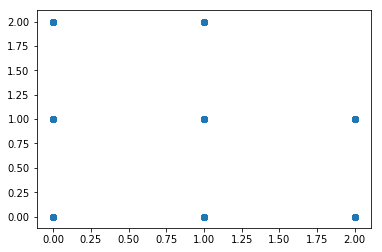

In [10]:
# Make cross validated predictions
predictions = cross_val_predict(RFC, X, y, cv=10)
plt.scatter(y, predictions)

accuracy = r2_score(y, predictions)
print('Cross-Predicted Accuracy: ', accuracy)


In [11]:
target_names = ['Bad', 'OK', 'Good']
class_names = target_names

In [12]:
# print(" *********** GaussianNB *********** ")
# y2_GNB_model = GNB.predict(x2)
# print(classification_report(y2, y2_GNB_model, target_names=target_names, sample_weight=None, digits=4))

# print(" *********** KNeighborsClassifier *********** ")
# y2_KNN_model = KNN.predict(x2)
# print(classification_report(y2, y2_KNN_model, target_names=target_names, sample_weight=None, digits=4))

# print(" *********** LogisticRegression *********** ")
# y2_LR_model = LR.predict(x2)
# print(classification_report(y2, y2_LR_model, target_names=target_names, sample_weight=None, digits=4))

# print(" *********** SVC *********** ")
# y2_SVC_model = SVC.predict(x2)
# print(classification_report(y2, y2_SVC_model, target_names=target_names, sample_weight=None, digits=4))


In [13]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in it.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [14]:
# # Compute confusion matrix
# cnf_matrix = confusion_matrix(y2, y2_GNB_model)
# np.set_printoptions(precision=2)

# # Plot non-normalized confusion matrix
# plt.figure()
# plot_confusion_matrix(cnf_matrix, classes=class_names,
#                       title='GaussianNB Confusion matrix, without normalization')

# # Plot normalized confusion matrix
# plt.figure()
# plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
#                       title='GaussianNB Normalized confusion matrix')

# plt.show();

In [15]:
# # Compute confusion matrix
# cnf_matrix = confusion_matrix(y2, y2_KNN_model)
# np.set_printoptions(precision=2)

# # Plot non-normalized confusion matrix
# plt.figure()
# plot_confusion_matrix(cnf_matrix, classes=class_names,
#                       title='KNeighborsClassifier Confusion matrix, without normalization')

# # Plot normalized confusion matrix
# plt.figure()
# plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
#                       title='KNeighborsClassifier Normalized confusion matrix')

# plt.show();

In [16]:
# # Compute confusion matrix
# cnf_matrix = confusion_matrix(y2, y2_SVC_model)
# np.set_printoptions(precision=2)

# # Plot non-normalized confusion matrix
# plt.figure()
# plot_confusion_matrix(cnf_matrix, classes=class_names,
#                       title='SVC Confusion matrix, without normalization')

# # Plot normalized confusion matrix
# plt.figure()
# plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
#                       title='SVC Normalized confusion matrix')

# plt.show();

In [17]:
# Try out these
# sklearn.multioutput.MultiOutputClassifier
# sklearn.multiclass.OutputCodeClassifier
# sklearn.multiclass.OneVsOneClassifier
# sklearn.multiclass.OneVsRestClassifier
# sklearn.model_selection.RandomizedSearchCV -- https://stackoverflow.com/questions/52029408/sklearn-mlp-classifier-hyperparameter-optimization-randomizedsearchcv
# sklearn.model_selection.check_cv
# sklearn.model_selection.StratifiedKFold
# sklearn.linear_model.RidgeClassifierCV
# sklearn.linear_model.PassiveAggressiveClassifier
# sklearn.linear_model.LogisticRegressionCV
# sklearn.gaussian_process.GaussianProcessClassifier
# sklearn.tree.DecisionTreeClassifier
# sklearn.tree.ExtraTreeClassifier
# Feature significance
# Narrow to Wide Splice
# Prev Deltas MA & Slope
